# Bayesian Modeling of a 1-Armed Bandit

_created by Austin Poor_

Using [`pystan`](https://mc-stan.org/) to model the probability of success from a random black-box 1-armed-bandit (a simplified version of the [multi-armed bandit problem](https://en.wikipedia.org/wiki/Multi-armed_bandit)).

The file [bandit.py](./bandit.py) has code for the "black-box", 1-armed bandit.

In [1]:
!pip install -qr requirements.txt

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pystan
import arviz as az

import bandit

In [3]:
# Supress extraneous pystan info
import logging
logging.getLogger("pystan").setLevel("ERROR")

In [4]:
# Set seed for reproducability
np.random.seed(0)

Create a `Bandit` object (from [bandit.py](./bandit.py)) that will pick a random $p$ value, between `0.0` and `1.0`, to define the 1-armed bandit's probability of success.

In [5]:
band = bandit.Bandit()
band

<One-Armed-Bandit::f0x7ff26c5a74f0>

Define the number of observations to perform, which will be used to model the hidden $p$ value, then get the observations from the `Bandit` object.

In [6]:
n_obs = 1_000

In [7]:
wins = band.draw(n_obs)

# Print the proportion of successes compared to
# the bandit's *secret* p-value.
print(f"observed win % = {wins / n_obs:.4f}")
print(f"real val of p  = {band._p:.4f}")

observed win % = 0.5370
real val of p  = 0.5488


Define and compile the `pystan` model.

Our observed data (number of trials and number of successes) are defined in the `data` block. The `parameters` block has the unknown $p$ value, which we're trying to predict. The `model` block tells stan how to link the `data` and the `parameters`.

(For more info on defining models in stan, see the [documentation](https://mc-stan.org/users/documentation/).)

In [8]:
bandit_model = """
data {
    int n_obs;
    int wins;
}

parameters {
    real<lower=0, upper=1.0> p;
}

model {
    wins ~ binomial(n_obs,p);
}
"""

In [9]:
model = pystan.StanModel(model_code=bandit_model)

Fit the `pystan` model by passing it the values for the `data` block. Then show the results of the fitted model.

In [10]:
fit = model.sampling(
    data={
        "n_obs": n_obs,
        "wins":  wins
    }
)
fit

Inference for Stan model: anon_model_485bc3b3ce9bdbdee788e5b3d377c5b1.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
p      0.54  4.2e-4   0.02    0.5   0.53   0.54   0.55   0.57   1573    1.0
lp__ -692.3    0.02   0.76 -694.6 -692.5 -692.0 -691.8 -691.8   1352    1.0

Samples were drawn using NUTS at Wed Sep  9 18:25:18 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

Examining the model results shows a mean $p$-value estimate of about `0.54` -- which is not too far off from the real, *hidden* $p$-value of `0.5488`. 

Now plot the posterior densities, a 94% [Highest Density Interval](https://www.sciencedirect.com/topics/mathematics/highest-density-interval), and show the real, *hidden* $p$-value.

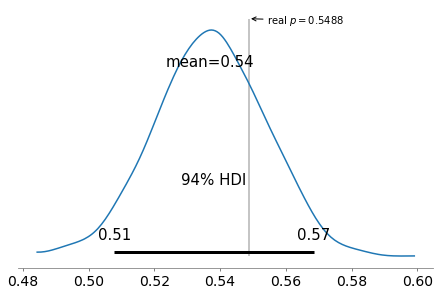

In [11]:
ax = az.plot_posterior(fit)
ymin, ymax = ax[0].get_ylim()
plt.vlines(band._p,0,ymax,alpha=0.3)
plt.annotate(
    f"real $p = {band._p:.4f}$",
    (band._p,ymax),
    (band._p*1.01,ymax*0.98),
    arrowprops={"arrowstyle":"->"},
    horizontalalignment="left"
)
plt.title("");

Create a KDE plot for the $p$ value estimates.

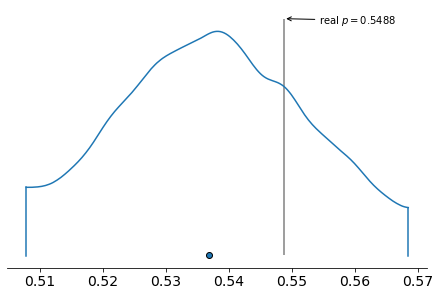

In [12]:
az.plot_density(fit)
ymin, ymax = ax[0].get_ylim()
plt.vlines(band._p,0,ymax,alpha=0.5)
plt.annotate(
    f"real $p = {band._p:.4f}$",
    (band._p,ymax),
    (band._p*1.01,ymax*0.98),
    arrowprops={"arrowstyle":"->"},
    horizontalalignment="left"
)
plt.title("");